In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random
import tqdm
import seaborn as sns
from os.path import join as pjoin
import scipy.io
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import json
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
import albumentations as album
import glob
import segmentation_models_pytorch as smp
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
DATA_DIR = os.path.join(".", "VOCdevkit", "VOC2010")
CONTECT_DIR = os.path.join(".", "trainval")
mat_paths = glob.glob(os.path.join(CONTECT_DIR, "*.mat"))

MODEL_DIR = os.path.join(".", "segmentation_models_voc" ,"timm-mobilenetv3_large_075")
model_path = os.path.join(MODEL_DIR, "best_model.pth")
image_size = 224

In [3]:
#データセット分ける
def split_train_val(root_path, mat_paths, train_ratio = 0.8):
    json_path = os.path.join(root_path, "train_val.json")
    if os.path.exists(json_path):
        json_open = open(json_path, 'r')
        return json.load(json_open)
    name_list = [os.path.basename(path).split(".")[0] for path in mat_paths]
    train_imgs, val_imgs = train_test_split(name_list, train_size=train_ratio)
    dic = {"train" : train_imgs,  "val" : val_imgs}
    with open(json_path, 'w') as f:
        json.dump(dic, f)
    return dic

img_dict = split_train_val(DATA_DIR, mat_paths)

In [ ]:
def create_gamma_img(gamma, img):
    gamma_cvt = np.zeros((256,1), dtype=np.uint8)
    for i in range(256):
        gamma_cvt[i][0] = 255*(float(i)/255)**(1.0/gamma)
    return cv2.LUT(img, gamma_cvt)

In [ ]:
def class_2_coler(num_class):
    #TODO クラスを変換する
    colors = []
    for i in range(num_class+1):
        r = i % 256
        g = i % 256 * 256
        b = i / (256 * 256)
        colors.append([r,  g, b])
    return colors

def one_hot_encode(mask_mat, n_classes):
    semantic_map = []
    for ind in range(n_classes + 1):
        equality = np.equal(mask_mat, ind)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return semantic_map

def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [4]:
class pascalVOCDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        root,
        context_root,
        file_list, #直接画像のlistを投げる
        size = image_size,
        augmentations=None, 
        preprocessing=None,
    ):
        self.root = root
        self.context_root = context_root
        self.size = size
        self.preprocessing = preprocessing
        self.augmentations = augmentations
        self.n_classes = 459
        self.files = file_list

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img_name = self.files[index]
        img_path = pjoin(self.root, "JPEGImages", img_name + ".jpg")
        mat_path = os.path.join(self.context_root, img_name) + ".mat"
        mat = scipy.io.loadmat(mat_path)
        #lbl_path = pjoin(self.root, "SegmentationClass/pre_encoded", im_name + ".png")
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        mask = np.array(mat["LabelMap"])

        r = min( self.size / img.shape[1], self.size /  img.shape[0])
        dsize = (int(img.shape[1] * r), int(img.shape[0] * r))
        image = cv2.resize(img, dsize = dsize)
        mask =  cv2.resize(mask, dsize = dsize)

        #TODO　実装
        mask_onehot = one_hot_encode(mask).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=img, mask=mask_onehot)
            img, mask_onehot = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=img, mask=mask_onehot)
            img, mask_onehot = sample['image'], sample['mask']
        return img, mask_onehot

    def get_pascal_labels(self):
        """
        return np.asarray(class_2_coler(self.n_classes))

In [ ]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()
    
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

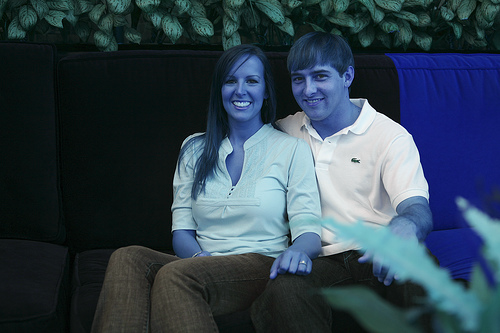

KeyboardInterrupt: 

In [10]:
#next. check　画像
train_dataset = pascalVOCDataset(DATA_DIR, CONTECT_DIR, img_dict["train"])
img, mask = train_dataset[0]


visualize(
    original_image = img,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), class_2_coler(459)),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [6]:
#augmentation
def get_training_augmentation():
    train_transform = [
        album.PadIfNeeded(min_height=image_size, min_width=image_size, always_apply=True, border_mode=0),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.5,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=image_size, min_width=image_size, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

{368, 420, 284}


In [ ]:
#モデル定義
ENCODER = 'timm-mobilenetv3_large_075'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = 459
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=CLASSES, 
    activation=ACTIVATION,
)

In [ ]:
# Get train and val dataset instances
train_dataset = pascalVOCDataset(
    DATA_DIR,
    CONTECT_DIR,
    img_dict["train"],
    augmentations=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
)

valid_dataset = pascalVOCDataset(
    DATA_DIR,
    CONTECT_DIR,
    img_dict["val"],
    augmentations=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

In [ ]:
# Hyperparameter
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 60

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

model_path = os.path.join(MODEL_DIR, "best_model.pth")

# load best saved model checkpoint from previous commit (if present)
if os.path.exists(model_path):
    model = torch.load(model_path, map_location=DEVICE)

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, model_path)
            print('Model saved!')